# CountGPVAE Simulation Demo

This notebook demonstrates how to use the modularized components of the CountGPVAE model.

In [42]:
import jax
import jax.nn as nn
from jax import lax, random
import jax.numpy as jnp
from jax.random import PRNGKey
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, RenyiELBO
import arviz as az
import sys
from pyprojroot2 import here
import time
sys.path.append(str(here() / "simulation study" / "src"))
# Import our modular components
from utils.kernels import exp_sq_kernel, M_g
from utils.loader import load_data
from models.gp import gp_aggr
from models.vae import vae_model, vae_guide, vae_decoder
from visualization.plotting import plot_process, plot_incidence_map
import matplotlib.pyplot as plt
from numpyro.infer import NUTS, MCMC, Predictive, init_to_median, init_to_uniform, init_to_sample, init_to_mean, init_to_value

## 1. Load Data

In [4]:
# Load the spatial grid and polygon data
spatial_data = load_data()
print(spatial_data.keys())

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])


## 2. Set up Model Parameters

In [5]:
# Model configuration
args = {
    "x": spatial_data["x"],
    "gp_kernel": exp_sq_kernel,
    "noise": 1.e-2,
    "jitter": 1.e-2,
    "M_lo": jnp.array(spatial_data["pol_pts_lo"])[0,:].reshape(1, -1),
    "M_hi":  jnp.array(spatial_data["pol_pts_hi"])[[0,4,9,14,19], :],
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    "vae_var": 0.1,
    "batch_size": 5,
    "hidden_dim": 50,
    "z_dim": 40,
    "learning_rate": 1e-3,
    "num_epochs": 100,
    "rng_key": PRNGKey(6)
}

## 3. Generate GP Samples

In [6]:
# Create predictive function for GP
from numpyro.infer import Predictive
# Draw samples from the prior
prior_samples = Predictive(gp_aggr, num_samples=5)(
    PRNGKey(6), 
    config=args
)

# transform prior samples to arviz inference object
prior_samples_arviz = az.from_numpyro(prior=prior_samples)

plot_process(prior_samples_arviz.prior.gp_aggr.values)

## 4. Train VAE

In [7]:
# Initialize SVI
optimizer = numpyro.optim.Adam(step_size=1e-3)
agg_gp_predictive = Predictive(gp_aggr,num_samples = 5)
@jax.jit
def epoch_train(rng_key, svi_state, num_train):
    def body_fn(i, val):
        rng_key_i = jax.random.fold_in(rng_key, i) #Array(2,)
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = jax.random.split(rng_key_i, 4) #Tuple(Array(2,) x 4)
        loss_sum, svi_state = val #val --svi_state
        
        batch = agg_gp_predictive(rng_key_i, args)["gp_aggr"] #(5,116) <- num_samples : 5, total_districts : 116
        #* svi is where the vae_model & vae_guide gets applied
        svi_state, loss = svi.update(svi_state, batch)
        loss_sum += loss / args["batch_size"]
        return loss_sum, svi_state 
    
    return lax.fori_loop(lower = 0, upper = num_train, body_fun=body_fn, init_val=(0.0, svi_state))

@jax.jit 
def eval_test(rng_key, svi_state, num_test):
    def body_fn(i, loss_sum):
        rng_key_i = jax.random.fold_in(rng_key, i)
        rng_key_i, rng_key_ls, rng_key_varm, rng_key_noise = jax.random.split(rng_key_i, 4)
        batch = agg_gp_predictive(rng_key_i, args)["gp_aggr"]
        #* svi is where the vae_model & vae_guide gets applied
        loss = svi.evaluate(svi_state, batch) / args["batch_size"]
        loss_sum += loss
        return loss_sum 
    
    loss = lax.fori_loop(lower = 0, upper = num_test,body_fun =  body_fn, init_val = 0.0)
    loss = loss / num_test 
    return loss

In [8]:
#-------------------------- Train VAE -------------------------- #
run = True
if run:
    adam = numpyro.optim.Adam(step_size = args["learning_rate"])
    svi = SVI(
        model=lambda batch: vae_model(batch, args["hidden_dim"], args["z_dim"], args["vae_var"]),
        guide=lambda batch: vae_guide(batch, args["hidden_dim"], args["z_dim"]),
        optim=adam, 
        loss=RenyiELBO(),
    )
    rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"],3)
    #(num_samples, num_regions) 
    init_batch = agg_gp_predictive(rng_key_samp, args)["gp_aggr"] #(num_samples, num_regions) <- i.e (5,58)
    svi_state = svi.init(rng_key_init, init_batch)

    test_loss_list = []

    for i in range(args["num_epochs"]):
        rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)
        t_start = time.time()
        num_train = 1000
        # Where forward/backward pass gets called for train
        train_loss , svi_state = epoch_train(rng_key_train, svi_state, num_train)
        num_test = 1000
        # Where forward/backward pass gets called for test
        test_loss = eval_test(rng_key_test, svi_state, num_test)
        test_loss_list += [test_loss]

        print("Epoch : {}, train loss : {:.2f}, test loss : {:.2f} ({:.2f} s.)".format(i, train_loss, test_loss, time.time() - t_start))
        if np.isnan(test_loss):
            break 

Epoch : 0, train loss : 1249032536064.00, test loss : 83416672.00 (1.30 s.)
Epoch : 1, train loss : 42383798272.00, test loss : 34568208.00 (0.00 s.)
Epoch : 2, train loss : 29321984000.00, test loss : 21217292.00 (0.00 s.)
Epoch : 3, train loss : 11317771264.00, test loss : 3051054.50 (0.00 s.)
Epoch : 4, train loss : 2555106816.00, test loss : 642606.56 (0.00 s.)
Epoch : 5, train loss : 648452480.00, test loss : 644805.38 (0.00 s.)
Epoch : 6, train loss : 682079232.00, test loss : 638743.69 (0.00 s.)
Epoch : 7, train loss : 549946048.00, test loss : 523573.06 (0.00 s.)
Epoch : 8, train loss : 603501440.00, test loss : 543574.12 (0.00 s.)
Epoch : 9, train loss : 548570560.00, test loss : 527711.44 (0.00 s.)
Epoch : 10, train loss : 586309824.00, test loss : 603968.38 (0.00 s.)
Epoch : 11, train loss : 567861568.00, test loss : 539008.31 (0.00 s.)
Epoch : 12, train loss : 566043264.00, test loss : 536295.31 (0.00 s.)
Epoch : 13, train loss : 583490688.00, test loss : 576124.25 (0.00 s.

In [9]:
 vae_params = svi.get_params(svi_state)

In [10]:
encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]
# save decoder params inside args
args["decoder_params"] = decoder_params

In [11]:
N = 6

def vae_sample(args):
    dec_params = args["decoder_params"]
    z_dim, h_dim = dec_params[0][0].shape 
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    dec_init_fn, dec_apply_fn = vae_decoder(h_dim, N)
    x_recon = dec_apply_fn(dec_params, z)
    vae_aggr = numpyro.deterministic("vae_aggr", x_recon)
    return vae_aggr

rng_key, rng_key_predict = random.split(random.PRNGKey(3))
vae_predictive = Predictive(vae_sample, num_samples = 5)
vae_draws = vae_predictive(rng_key_predict, args)["vae_aggr"] 

In [12]:
plot_process(jnp.expand_dims(vae_draws, axis = 0))

In [34]:
# ------------------- Func for Agg VAE Prev ------------------- #
def prev_model_vae_aggr(config=None):

    if config is None:
        config = {}
        
    # Set defaults
    x = config.get('x', None)
    gp_kernel = config.get('gp_kernel', exp_sq_kernel)
    noise = config.get('noise', 1e-4)
    jitter = config.get('jitter', 1e-4)
    M_lo = config.get('M_lo', None)
    M_hi = config.get('M_hi', None)
    kernel_length_prior = config.get('kernel_length', dist.InverseGamma(4, 1))
    kernel_var_prior = config.get('kernel_var', dist.LogNormal(0, 0.1))
    pop_density = config.get('pop_density', None)
    urban_frac = config.get('urban_frac', None)
    hdi_index = config.get('hdi_index', None)
    total_population = config.get('total_population', None)
    count_data = config.get('count', None)
    is_prior_pred = config.get('prior_pred', False)
    out_dims = config.get('out_dims', 6)
    # GP
    config_gp = config.copy()
    config_gp['x'] = x
    config_gp['gp_kernel'] = gp_kernel
    config_gp['noise'] = noise
    config_gp['jitter'] = jitter
    config_gp['M_lo'] = M_lo
    config_gp['M_hi'] = M_hi
    config_gp['kernel_length'] = kernel_length_prior
    config_gp['kernel_var'] = kernel_var_prior
    # Call gp_aggr
    decoder_params = config["decoder_params"]
    z_dim, hidden_dim = decoder_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    _, decoder_apply = vae_decoder(hidden_dim, out_dims) #Instantiate decoder
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_apply(decoder_params, z))
    s = numpyro.sample("sigma1", dist.HalfNormal(200))

    vae = numpyro.deterministic("vae", s * vae_aggr)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(100, 10))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI
    b_urban = numpyro.sample("b_urban", dist.Normal(0, 1))  # Effect of urbanicity

    # Linear predictor
    # lp = numpyro.deterministic("lp", (b0 + 
    #                                   aggr_gp + 
    #                                   b_pop_density * pop_density + 
    #                                   b_hdi * hdi_index + 
    #                                   b_urban * urban_frac))  #
    lp = numpyro.deterministic("lp", nn.softplus(b0 + 
                                      vae + 
                                      b_pop_density * pop_density + 
                                      b_hdi * hdi_index + 
                                      b_urban * urban_frac)) 
    
   
    sigma = numpyro.sample("sigma", dist.HalfNormal(5))
    pred_cases = numpyro.sample(
        "pred_cases",
        dist.Normal(lp, sigma),
        obs=None if is_prior_pred else count_data
    )
    return pred_cases

In [45]:
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it 
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')
# make sure we use only one year of data 
year_data = spatial_data["df_lo"].Year.max()
print(f'We are using data for the year {year_data}\n')
# let us filter the data for the most recent year
# let us filter the data for the most recent year
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()  
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population
total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2023



In [32]:
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"])[0,:].reshape(1, -1),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"])[[0,4,9,14,19], :],
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': False,
    "decoder_params": decoder_params,
    "out_dims": 6 # [lo + hi] 
}

In [38]:
model =  prev_model_vae_aggr
# Define the sampler
sampler = NUTS(model, target_accept_prob = 0.99, max_tree_depth = 20)
mcmc = MCMC(sampler, # change for later run to 0.99 and 20
            num_warmup=1000,
            num_samples=1000,
            num_chains=4,
            chain_method="vectorized",
            )
start = time.time()
mcmc.run(PRNGKey(2), config_count)
end = time.time()
t_elapsed_min = round((end - start) / 60)
print(f"Time taken to run MCMC: {t_elapsed_min} minutes")

sample: 100%|██████████| 2000/2000 [20:17<00:00,  1.64it/s] 

Time taken to run MCMC: 20 minutes


In [39]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

# %%
print(mcmc.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "vae"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0    100.13     10.12    100.10     83.44    116.93   3542.35      1.00
          b_hdi      0.05      1.01      0.06     -1.70      1.59   1804.06      1.00
  b_pop_density      0.10      1.02      0.09     -1.67      1.67    348.36      1.01
        b_urban      0.08      0.99      0.10     -1.59      1.65   1432.68      1.00
  pred_cases[0]   1326.48   1671.54    618.96    -28.92   3524.47     18.18      1.25
  pred_cases[1]    363.13    343.60    283.40    -18.29    807.77     24.81      1.21
  pred_cases[2]    111.37    144.47     32.45    -15.20    326.21    116.46      1.04
  pred_cases[3]    407.04    401.35    298.11    -13.31    968.02     36.00      1.16
  pred_cases[4]    392.61    439.57    255.94    -17.99    995.79     32.18      1.19
  pred_cases[5]    510.63    482.71    359.87    -10.06   1167.45     20.03      1.24
          sigma      4.52      2.97      3.93      0.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1326.484,1671.541,-28.919,4378.599,442.507,462.974,17.0,19.0,1.19
pred_cases[1],363.128,343.604,-18.286,970.093,83.762,75.466,21.0,24.0,1.16
pred_cases[2],111.373,144.474,-14.259,385.721,14.454,9.440,116.0,359.0,1.03
pred_cases[3],407.039,401.352,-22.230,1144.018,82.152,76.221,28.0,42.0,1.13
pred_cases[4],392.611,439.574,-22.368,1236.510,97.474,92.376,25.0,30.0,1.15
pred_cases[5],510.632,482.710,-18.248,1392.723,124.747,122.860,19.0,17.0,1.18
lp[0],1326.550,1671.534,0.000,4381.641,442.442,463.043,16.0,19.0,1.21
lp[1],362.951,343.422,0.000,961.743,83.725,75.510,21.0,24.0,1.16
lp[2],111.359,144.485,0.000,383.042,14.492,9.366,96.0,151.0,1.04
lp[3],407.138,401.193,0.000,1146.771,82.235,76.322,27.0,42.0,1.14


In [47]:
mean_pred_cases = numpyro_data.posterior.pred_cases.values.mean(axis=(0,1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

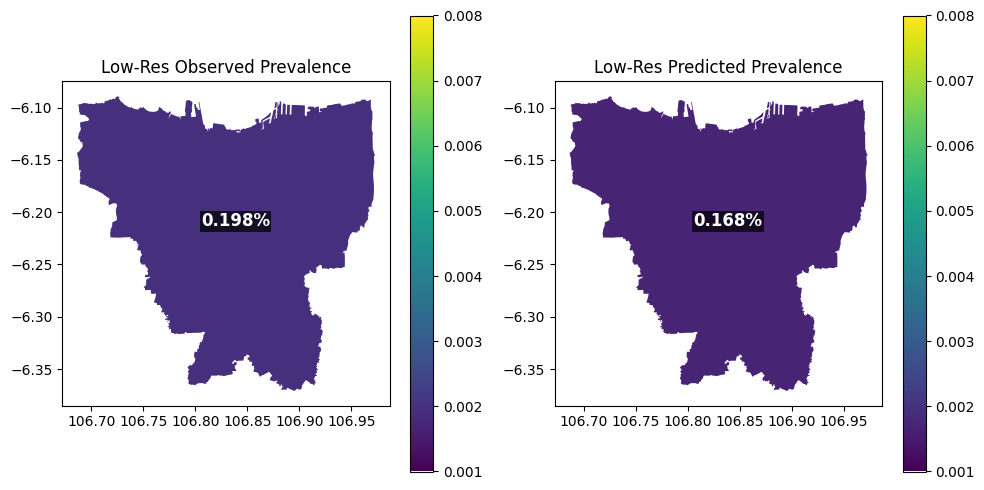

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

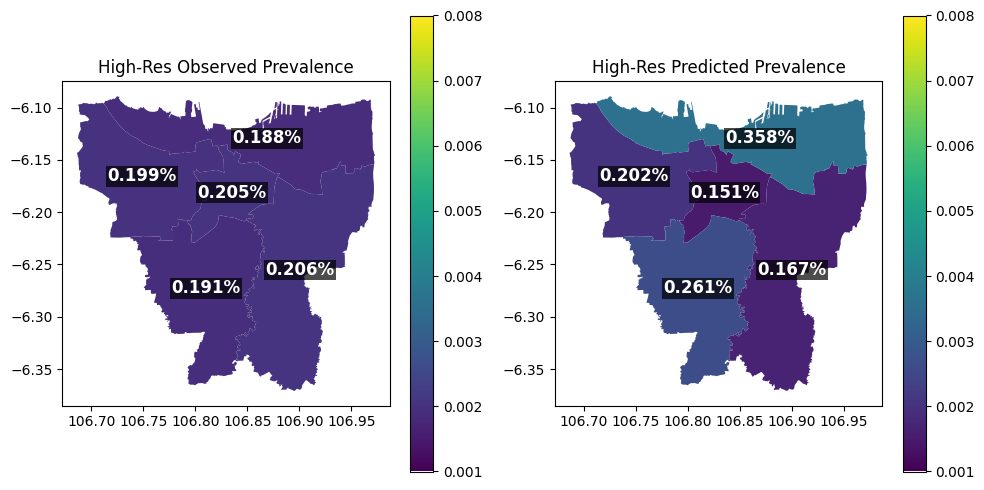

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()